## 1. imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import Flag, auto

## 2. implementation

### 2.1. Cost functions

In [2]:
class ICost:
    @staticmethod
    def cost(p_y_true, p_y_pred):
        return
    
    @staticmethod
    def cost_derivative(p_y_true, p_y_pred):
        return
    
    @staticmethod
    def cost_type():
        return

In [3]:
class Cost:
    class Type(Flag):
        MSE = auto()
        
    @staticmethod
    def from_type(p_type):
        match p_type:
            case Cost.Type.MSE:
                return Cost.MSE()
            case _:
                print("Warning: Unknown cost function type. Using MSE instead.")
                return Cost.MSE()
    
    class MSE(ICost):
        @staticmethod
        def cost(p_y_true, p_y_pred):
            return np.mean((p_y_pred - p_y_true) ** 2)

        @staticmethod
        def cost_derivative(p_y_true, p_y_pred):
            return 2 / len(p_y_pred) * (p_y_pred - p_y_true)

        @staticmethod
        def cost_type():
            return Cost.Type.MSE

### 2.2. Activation functions

In [4]:
class IActivation:
    @staticmethod
    def activation(x):
        return
    
    @staticmethod
    def activation_derivative(x):
        return
    
    @staticmethod
    def get():
        return
    
    @staticmethod
    def activation_type():
        return

In [5]:
class Activation:
    class Type(Flag):
        Sigmoid = auto()
        Linear = auto()
    
    @staticmethod
    def from_type(p_type):
        match p_type:
            case Activation.Type.Sigmoid:
                return Activation.Sigmoid()
            case Activation.Type.Linear:
                return Activation.Linear()
            case _:
                print("Warning: Unknown activation function type. Using Sigmoid instead.")
                return Activation.Sigmoid()
    
    class Sigmoid(IActivation):
        @staticmethod
        def activation(x):
            return 1 / (1 + np.exp(-x))

        @staticmethod
        def activation_derivative(x):
            s = Activation.Sigmoid.activation(x)
            return s * (1 - s)
        
        @staticmethod
        def get():
            return Activation.Sigmoid.activation, Activation.Sigmoid.activation_derivative
        
        @staticmethod
        def activation_type():
            return Activation.Type.Sigmoid
    
    class Linear(IActivation):
        @staticmethod
        def activation(x):
            return x

        @staticmethod
        def activation_derivative(x):
            return np.ones(shape=x.shape)
        
        @staticmethod
        def get():
            return Activation.Linear.activation, Activation.Linear.activation_derivative
        
        @staticmethod
        def activation_type():
            return Activation.Type.Linear

### 2.3. Layer

In [6]:
class Layer:
    def __init__(self, p_in, p_out, p_act, p_w_init):
        n = p_in + p_out
        w_shape = (p_in, p_out)
        b_shape = (1, p_out)
        
        self.x = 0
        self.z = 0
        
        match p_w_init:
            case "unif":
                self.weights = np.random.uniform(0, 1, size=w_shape)
            case "Xavier":
                a = np.sqrt(6 / n)
                self.weights = np.random.uniform(-a, a, size=w_shape)
            case "He":
                self.weights = np.random.normal(0, np.sqrt(2 / n), size=w_shape)
        self.biases = np.zeros(shape=b_shape)
        self.weights_grad = np.zeros(shape=w_shape)
        self.biases_grad = np.zeros(shape=b_shape)
        self.weights_Momentum = np.zeros(shape=w_shape)
        self.biases_Momentum = np.zeros(shape=b_shape)
        self.weights_RMSProp = np.zeros(shape=w_shape)
        self.biases_RMSProp = np.zeros(shape=b_shape)
        
        self.act, self.act_der = Activation.from_type(p_act).get()
        
        return
    
    def forward(self, p_input):
        self.x = p_input
        self.z = np.dot(self.x, self.weights) + self.biases
        
        return self.act(self.z)

### 2.4. Network

In [7]:
class Network:
    def __init__(self, p_layers, p_act=Activation.Type.Sigmoid, p_out_act=Activation.Type.Linear, p_w_init="He"):
        self.L = len(p_layers) - 1
        self.layers = []
        
        self.mean_x = 0
        self.std_x = 1       
        self.mean_y = 0
        self.std_y = 1
        
        for l in range(self.L - 1):
            self.layers.append(Layer(p_layers[l], p_layers[l + 1], p_act, p_w_init))
        self.layers.append(Layer(p_layers[-2], p_layers[-1], p_out_act, p_w_init))
        
        return
    
    def set_normals(self, p_x, p_y):
        self.mean_x = p_x.mean()
        self.std_x = p_x.std()
        self.mean_y = p_y.mean()
        self.std_y = p_y.std()
        
        return
    
    def normalise(self, p_x):
        return (p_x - self.mean_x) / self.std_x
    
    def denormalise(self, p_y):
        return p_y * self.std_y + self.mean_y
    
    def predict(self, p_input):
        result = self.normalise(p_input)
        
        for layer in self.layers:
            result = layer.forward(result)
            
        return self.denormalise(result)
    
    def train(self, p_x, p_y, p_epochs, p_lr, p_mb_size, p_shuffle, p_method="SGD", p_beta=0.9, p_cost=Cost.Type.MSE):
        n = len(p_x)
        
        if type(p_mb_size) == float and 0 < p_mb_size < 1:
            p_mb_size = int(p_mb_size * n)
            
        self.set_normals(p_x, p_y)
        
        cost_hdl = Cost.from_type(p_cost)
        costs = []
        
        for e in range(p_epochs):
            indexes = list(range(n))
            
            if p_shuffle:
                np.random.shuffle(indexes)
                
            for k in range(0, n, p_mb_size):
                mb_indexes = indexes[k:k + p_mb_size]
                
                y_pred = self.predict(p_x[mb_indexes])

                delta = (y_pred - p_y[mb_indexes]) / len(p_x[mb_indexes])
                for l in reversed(range(1, self.L)):
                    self.layers[l].weights_grad = np.dot(self.layers[l].x.T, delta)
                    self.layers[l].biases_grad = np.reshape(np.sum(delta, axis = 0), self.layers[l].biases.shape)
                    delta = np.dot(delta, self.layers[l].weights.T) * self.layers[l - 1].act_der(self.layers[l - 1].z)
                self.layers[0].weights_grad = np.dot(self.layers[0].x.T, delta)
                self.layers[0].biases_grad = np.reshape(np.sum(delta, axis = 0), self.layers[0].biases.shape)
        
                match p_method:
                    case "Momentum":
                        self.use_momentum(p_beta)
                    case "RMSProp":
                        self.use_RMSProp(p_beta)
                
                for layer in self.layers:
                    layer.weights -= p_lr * layer.weights_grad 
                    layer.biases -= p_lr * layer.biases_grad 
            
            costs.append(cost_hdl.cost(p_y, self.predict(p_x)))
        
        return costs
    
    def use_momentum(self, p_beta):
        for layer in self.layers:
            layer.weights_Momentum = layer.weights_grad + layer.weights_Momentum * p_beta
            layer.biases_Momentum = layer.biases_grad + layer.biases_Momentum * p_beta
            
            layer.weights_grad = layer.weights_Momentum
            layer.biases_grad = layer.biases_Momentum
        
        return
    
    def use_RMSProp(self, p_beta):
        for layer in self.layers:
            layer.weights_RMSProp = p_beta * layer.weights_RMSProp + (1 - p_beta) * layer.weights_grad ** 2
            layer.biases_RMSProp = p_beta * layer.biases_RMSProp + (1 - p_beta) * layer.biases_grad ** 2
            
            layer.weights_grad /= np.sqrt(layer.weights_RMSProp) + 0.000001
            layer.biases_grad /= np.sqrt(layer.biases_RMSProp) + 0.000001

        return

## 3. testing model

In [8]:
def present(p_layers, p_x, p_y, p_epochs, p_lr, p_mb_size, p_shuffle, p_w_init="He"):
    network_Momentum = Network(p_layers, p_w_init=p_w_init)
    Momentum_costs = network_Momentum.train(p_x, p_y, p_epochs, p_lr, p_mb_size, p_shuffle, "Momentum")
    
    network_RMSProp = Network(p_layers, p_w_init=p_w_init)
    RMSProp_costs = network_RMSProp.train(p_x, p_y, p_epochs, p_lr, p_mb_size, p_shuffle, "RMSProp")
    
    network_SGD = Network(p_layers, p_w_init=p_w_init)
    SGD_costs = network_SGD.train(p_x, p_y, p_epochs, p_lr, p_mb_size, p_shuffle)
    
    plt.plot(range(p_epochs), Momentum_costs)
    plt.plot(range(p_epochs), RMSProp_costs)
    plt.plot(range(p_epochs), SGD_costs)
    plt.legend(['Momentum', 'RMSProp', 'SGD'])
    plt.show()
    
    print(f"Momentum last mse = {Momentum_costs[-1]}")
    print(f"RMSProp last mse  = {RMSProp_costs[-1]}")
    print(f"SGD last mse      = {SGD_costs[-1]}")
    
    return network_Momentum, network_RMSProp, network_SGD

In [9]:
def plot_predict(p_model, X_train, y_train, X_test, y_test):
    y_train_pred = p_model.predict(X_train)
    y_test_pred = p_model.predict(X_test)

    print(f"train MSE = {Cost.MSE().cost(y_train, y_train_pred)}")
    print(f"test MSE = {Cost.MSE().cost(y_test, y_test_pred)}")

    plt.scatter(X_train, y_train)
    plt.scatter(X_train, y_train_pred)
    plt.legend(['true', 'predicted'])
    plt.title('train')
    plt.show()

    plt.scatter(X_test, y_test)
    plt.scatter(X_test, y_test_pred)
    plt.legend(['true', 'predicted'])
    plt.title('test')
    plt.show()

### 3.1. square-large

In [10]:
square_large_train = pd.read_csv('mio1/regression/square-large-training.csv', index_col=0)
square_large_test = pd.read_csv('mio1/regression/square-large-test.csv', index_col=0)

In [11]:
square_large_X_train = square_large_train.drop(columns='y')
square_large_y_train = square_large_train['y']

square_large_X_test = square_large_test.drop(columns='y')
square_large_y_test = square_large_test['y']

sq_lar_X_train = square_large_X_train.to_numpy().reshape((square_large_X_train.shape[0], 1))
sq_lar_y_train = square_large_y_train.to_numpy().reshape((square_large_y_train.shape[0], 1))

sq_lar_X_test = square_large_X_test.to_numpy().reshape((square_large_X_test.shape[0], 1))
sq_lar_y_test = square_large_y_test.to_numpy().reshape((square_large_y_test.shape[0], 1))

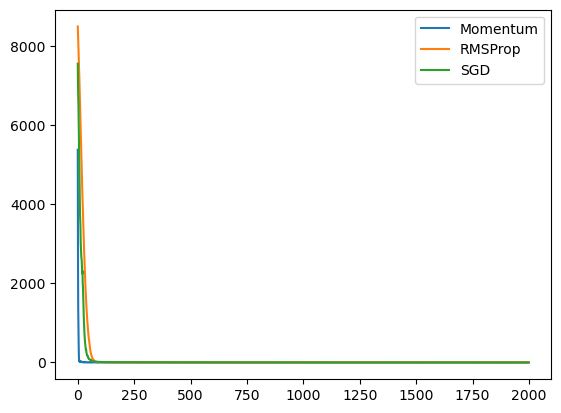

Momentum last mse = 0.1792253101642186
RMSProp last mse  = 0.7778230245103582
SGD last mse      = 0.16592614736328887


In [12]:
network_Momentum, network_RMSProp, network_SGD = present([1, 6, 6, 1], sq_lar_X_train, sq_lar_y_train, 2000, 0.001, 0.01, True)

train MSE = 0.1792253101642186
test MSE = 49.46523461282139


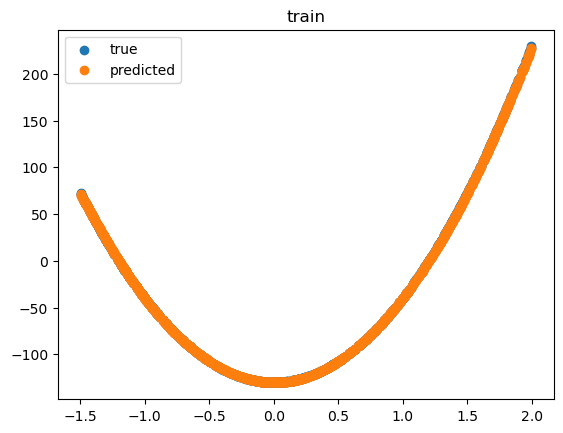

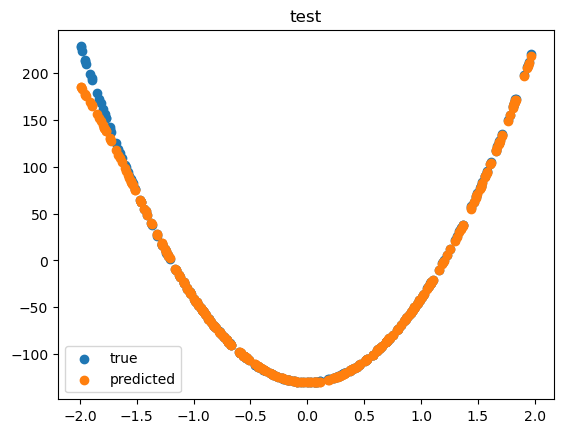

In [13]:
plot_predict(network_Momentum, sq_lar_X_train, sq_lar_y_train, sq_lar_X_test, sq_lar_y_test)

train MSE = 0.7778230245103582
test MSE = 32.499840325009146


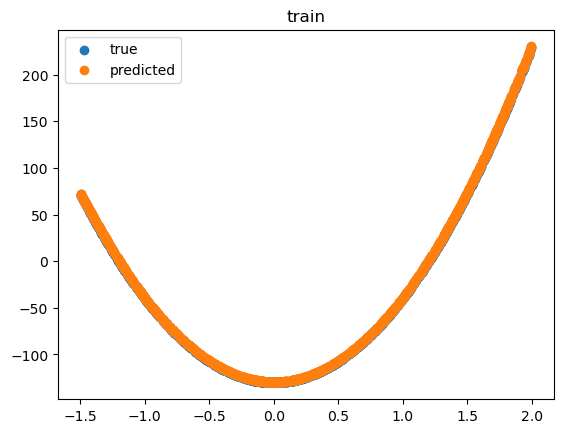

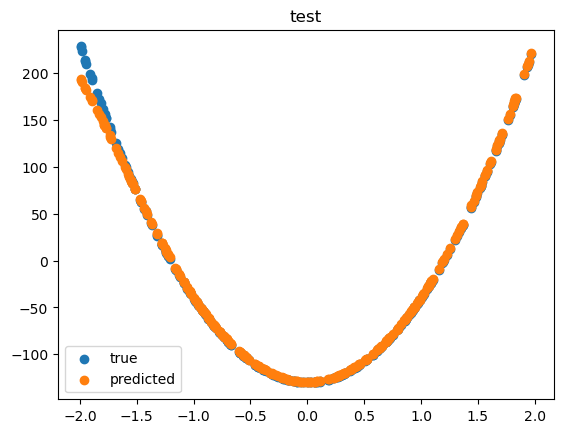

In [14]:
plot_predict(network_RMSProp, sq_lar_X_train, sq_lar_y_train, sq_lar_X_test, sq_lar_y_test)

train MSE = 0.16592614736328887
test MSE = 69.73355824212095


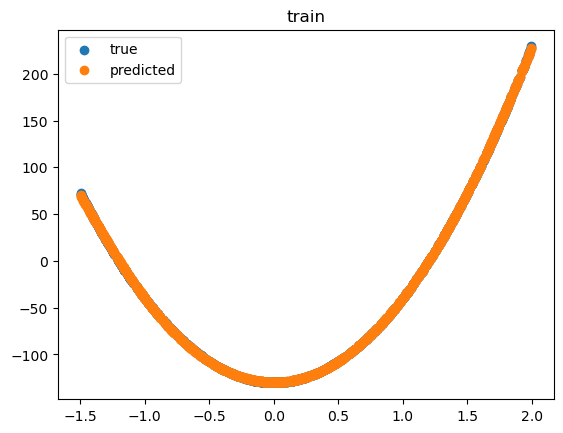

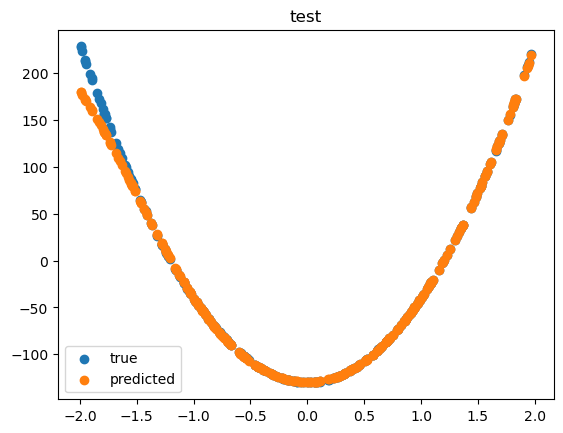

In [15]:
plot_predict(network_SGD, sq_lar_X_train, sq_lar_y_train, sq_lar_X_test, sq_lar_y_test)

### 3.2. steps-large

In [16]:
steps_large_train = pd.read_csv('mio1/regression/steps-large-training.csv', index_col=0)
steps_large_test = pd.read_csv('mio1/regression/steps-large-test.csv', index_col=0)

In [17]:
steps_large_X_train = steps_large_train.drop(columns='y')
steps_large_y_train = steps_large_train['y']

steps_large_X_test = steps_large_test.drop(columns='y')
steps_large_y_test = steps_large_test['y']

st_lar_X_train = steps_large_X_train.to_numpy().reshape((steps_large_X_train.shape[0], 1))
st_lar_y_train = steps_large_y_train.to_numpy().reshape((steps_large_y_train.shape[0], 1))

st_lar_X_test = steps_large_X_test.to_numpy().reshape((steps_large_X_test.shape[0], 1))
st_lar_y_test = steps_large_y_test.to_numpy().reshape((steps_large_y_test.shape[0], 1))

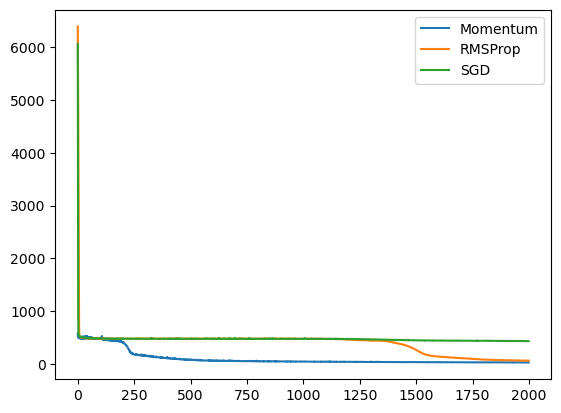

Momentum last mse = 30.376560338132094
RMSProp last mse  = 64.79494362608479
SGD last mse      = 434.28577550750373


In [18]:
network_Momentum, network_RMSProp, network_SGD = present([1, 6, 6, 1], st_lar_X_train, st_lar_y_train, 2000, 0.001, 0.01, True)

train MSE = 30.376560338132094
test MSE = 28.13260796401374


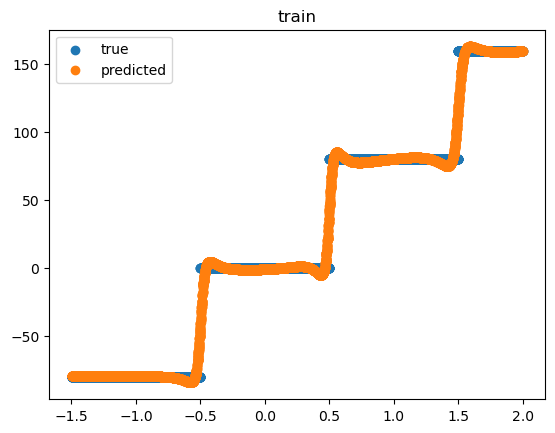

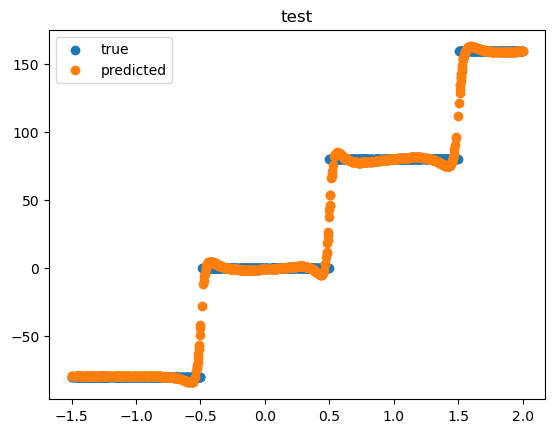

In [19]:
plot_predict(network_Momentum, st_lar_X_train, st_lar_y_train, st_lar_X_test, st_lar_y_test)

train MSE = 64.79494362608479
test MSE = 64.92186921385724


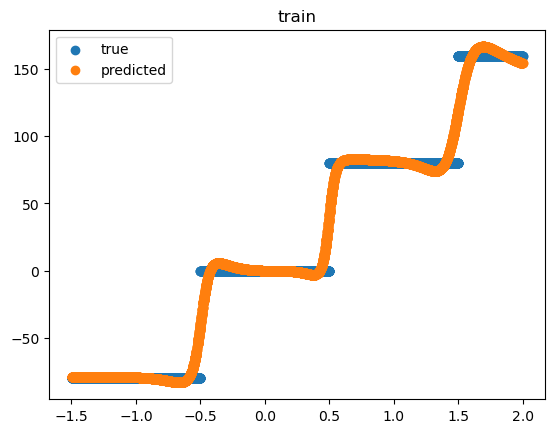

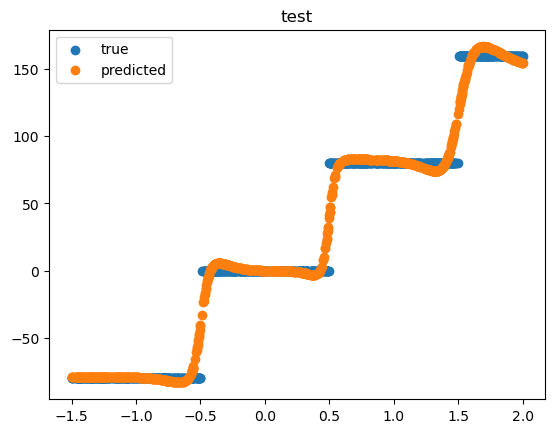

In [20]:
plot_predict(network_RMSProp, st_lar_X_train, st_lar_y_train, st_lar_X_test, st_lar_y_test)

train MSE = 434.28577550750373
test MSE = 438.0702491212453


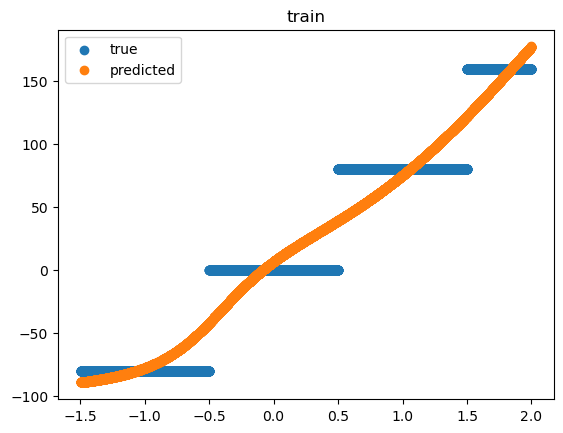

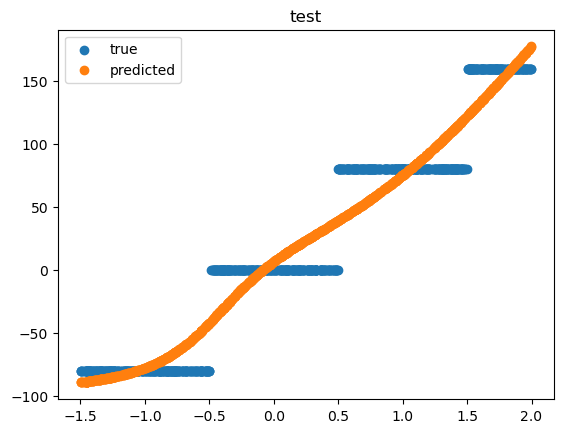

In [21]:
plot_predict(network_SGD, st_lar_X_train, st_lar_y_train, st_lar_X_test, st_lar_y_test)

### 3.3. multimodal-large

In [22]:
multimodal_large_train = pd.read_csv('mio1/regression/multimodal-large-training.csv')
multimodal_large_test = pd.read_csv('mio1/regression/multimodal-large-test.csv')

In [23]:
multimodal_large_X_train = multimodal_large_train.drop(columns='y')
multimodal_large_y_train = multimodal_large_train['y']

multimodal_large_X_test = multimodal_large_test.drop(columns='y')
multimodal_large_y_test = multimodal_large_test['y']

mul_lar_X_train = multimodal_large_X_train.to_numpy().reshape((multimodal_large_X_train.shape[0], 1))
mul_lar_y_train = multimodal_large_y_train.to_numpy().reshape((multimodal_large_y_train.shape[0], 1))

mul_lar_X_test = multimodal_large_X_test.to_numpy().reshape((multimodal_large_X_test.shape[0], 1))
mul_lar_y_test = multimodal_large_y_test.to_numpy().reshape((multimodal_large_y_test.shape[0], 1))

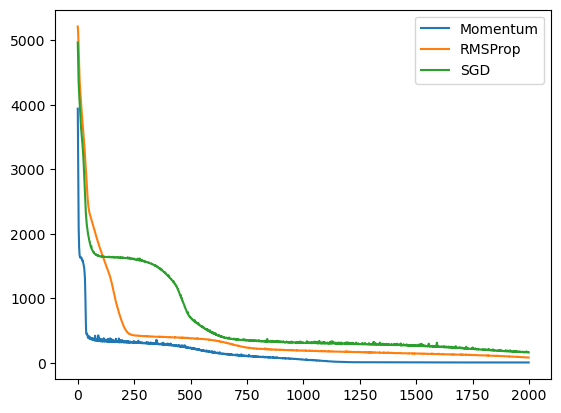

Momentum last mse = 7.746387726069134
RMSProp last mse  = 84.00795431677041
SGD last mse      = 163.39807593074568


In [24]:
network_Momentum, network_RMSProp, network_SGD = present([1, 6, 6, 1], mul_lar_X_train, mul_lar_y_train, 2000, 0.001, 0.01, True)

train MSE = 7.746387726069134
test MSE = 2.9587476140889284


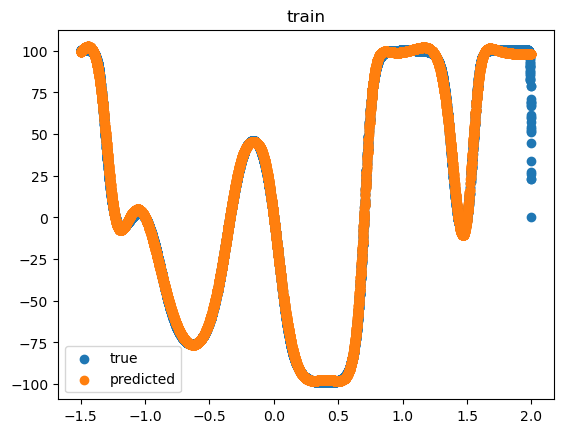

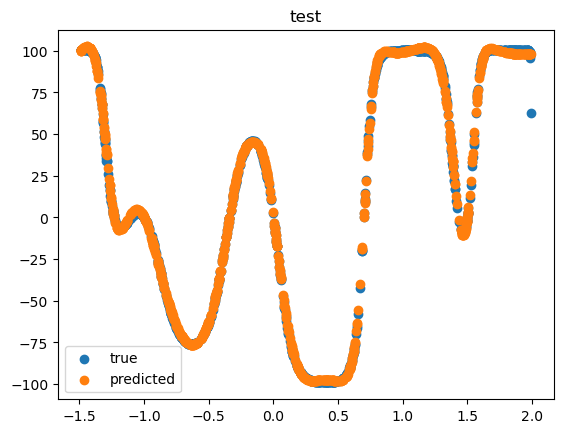

In [25]:
plot_predict(network_Momentum, mul_lar_X_train, mul_lar_y_train, mul_lar_X_test, mul_lar_y_test)

train MSE = 84.00795431677041
test MSE = 85.06232884189006


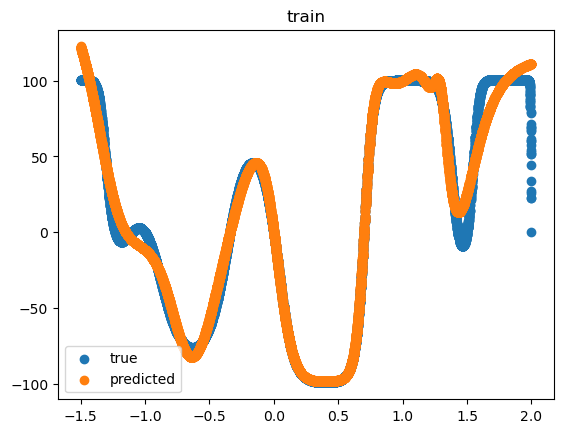

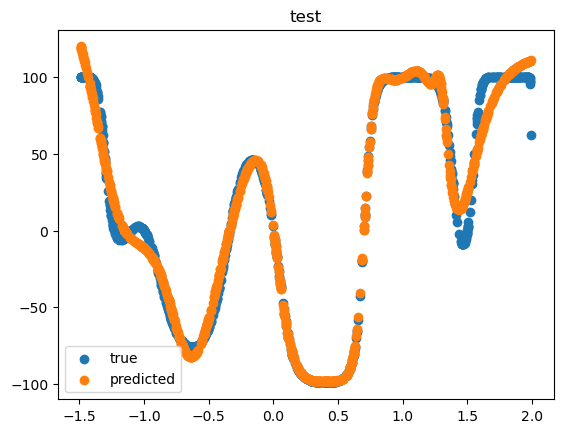

In [26]:
plot_predict(network_RMSProp, mul_lar_X_train, mul_lar_y_train, mul_lar_X_test, mul_lar_y_test)

train MSE = 163.39807593074568
test MSE = 160.93284637993816


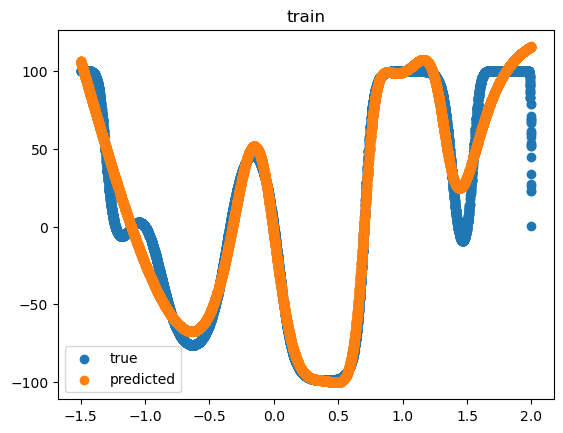

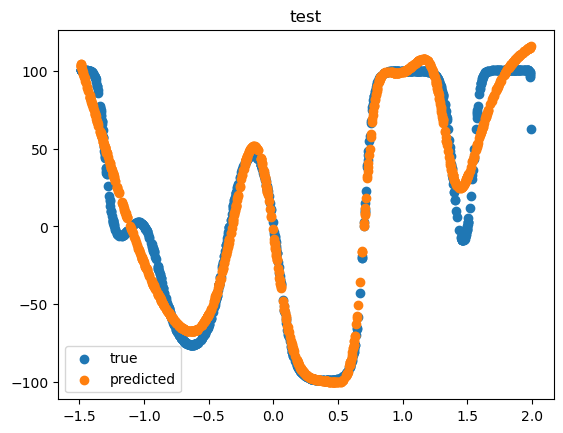

In [27]:
plot_predict(network_SGD, mul_lar_X_train, mul_lar_y_train, mul_lar_X_test, mul_lar_y_test)